In [1]:
#LFP filtering - Monroe 
%reload_ext autoreload
%autoreload 2

In [583]:
# run this cell
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np

## We also import a bunch of tables so that we can call them easily

from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  SortGroup, SpikeSortingFilterParameters, SpikeSortingArtifactDetectionParameters,
                                  SpikeSortingRecordingSelection, SpikeSortingRecording, 
                                  SpikeSortingWorkspace, 
                                  SpikeSorter, SpikeSorterParameters, SortingID,
                                  SpikeSortingSelection, SpikeSorting, 
                                  SpikeSortingMetricParameters,
                                  ModifySortingParameters, ModifySortingSelection, ModifySorting, 
                                  AutomaticCurationParameters, AutomaticCurationSelection,
                                  AutomaticCuration,
                                  CuratedSpikeSortingSelection, CuratedSpikeSorting,
                                  UnitInclusionParameters,
                                  FirFilter,
                                  IntervalList, SortInterval,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from nwb_datajoint.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from nwb_datajoint.common.nwb_helper_fn  import 

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
#do this from the tutorial notebook. close everything, close jupyter server... clean start!

SyntaxError: invalid syntax (2499308070.py, line 38)

#### Next we select the NWB file, which corresponds to the dataset we want to extract LFP from

In [5]:
FirFilter().create_standard_filters()
FirFilter()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Delta 0.5-4 Hz,1000,lowpass,0.25,0.5,4.0,5.0,delta filter for 1 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,30000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
Ripple 150-250 Hz,1000,lowpass,140.0,150.0,250.0,260.0,ripple band filter for 1 kHz data,=BLOB=,=BLOB=
Theta 5-11 Hz,1000,lowpass,4.0,5.0,11.0,12.0,theta filter for 1 KHz data,=BLOB=,=BLOB=


### choose every 4th electrode 

In [21]:
# run this cell
nwb_file_name = 'senor20201030_.nwb'
electrode_ids = (Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_id')
electrode_groups= (Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_group_name')

#This would be a nice way to do this, if some electrodes werent missing. (For beans eg) 
print(((Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_id'))[range(0, len(electrode_ids),4)])
print(((Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_group_name'))[range(0,  len(electrode_ids),4)])
#[range(0, 256, 4)])


[  0   4  40  44  48  52  56  60  64  68  72  76   8  80  84  88  92  96
 100 104 108 112 116  12 120 124 128 132 136 140 144 148 152 156 160 164
 168 172 176 180 184 188 192 196 200 204 208 212 216 220 224 228 232 236
 240 244 248 252 256 260 264 268 272 276 280 284 288 292 296 300 304 308
 312 316 320 324 328 332 336 340 344 348 352 356 360 364 368 372 376 380
  16  20  24  28  32  36]
['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '32' '32' '32'
 '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32'
 '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32' '32'
 '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33'
 '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33' '33'
 '33' '33' '33' '33' '4' '5' '6' '7' '8' '9']


In [430]:
lfp_electrode_ids = (Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_id')[range(0, len(electrode_ids),4)]
#luckily the references are all included here for later so dont have to append! at least for now, but one day might wanna add 

In [431]:
lfp_electrode_ids

array([  0,   4,  40,  44,  48,  52,  56,  60,  64,  68,  72,  76,   8,
        80,  84,  88,  92,  96, 100, 104, 108, 112, 116,  12, 120, 124,
       128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176,
       180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228,
       232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280,
       284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332,
       336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380,  16,
        20,  24,  28,  32,  36])

In [591]:
#Here, for the purposes of the theta filtering where we want to use references, I will pick the reference electrodes to save for later 
#will need to think about this in the long run. because i want to load all into LFP but only some into theta-band.. so maybe I should actually do this later. 
#for now i should set up to do every 4th tetrode 
references = np.unique((Electrode() & {'nwb_file_name' : nwb_file_name}).fetch('original_reference_electrode'))
references
#dont inlcude bad channels

array([ 17,  48,  64, 288])

In [599]:
#why is 48 one of them? corresponds to tetrode 13? Its the reference for the bad channels! 
(Electrode() & {'nwb_file_name' : nwb_file_name}) #&{'original_reference_electrode':48})#.fetch('original_reference_electrode')

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,bad_channel if electrode is 'good' or 'bad' as observed during recording,x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal -- current workaround
senor20201030_.nwb,0,0,tetrode_12.5,0,0,6,0,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,1,tetrode_12.5,0,1,6,1,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,2,tetrode_12.5,0,2,6,2,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,3,tetrode_12.5,0,3,6,3,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,4,tetrode_12.5,0,0,6,4,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,5,tetrode_12.5,0,1,6,5,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,6,tetrode_12.5,0,2,6,6,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,7,tetrode_12.5,0,3,6,7,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,40,tetrode_12.5,0,0,6,40,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,41,tetrode_12.5,0,1,6,41,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [27]:
#add the references to the group of electrodes that well load in case they dont fall into every 4th
for item in range(len(references)):
    np.append(lfp_electrode_ids,item) if item not in lfp_electrode_ids else None

In [351]:
# Electrode() & {'nwb_file_name':'senor20201031_.nwb'}
# instead of manually choosing electrodes to look at, we should: 
#look at only probe_type = tetrode
#for ix in electrode_group_name.max()
#electrode group = electrode group name(ix) 
#find min electrode id in that group 
#append that electrode id to list, like wire list. 
LFP()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
beans20190718_dgramling_.nwb,lfp valid times,LFP 0-400 Hz,20000,beans20190718_dgramling_5ZH6VUWBOC.nwb,35d1ec01-a384-48ff-abce-7f148c768220,1000.0
beans20190718_emonroe_.nwb,lfp valid times,LFP 0-400 Hz,20000,beans20190718_emonroe_20JF4EZUQ6.nwb,465c629a-a320-4088-a72d-b46ac1a3b444,1000.0
CH5_20210109_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210109_XYUNV6CQF6.nwb,747956d0-7009-41f1-b1a7-87ddc95e9647,1000.0
CH5_20210110_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210110_NX65FU33JE.nwb,7df0a6df-8139-48a1-aab6-556e2db72db5,1000.0
CH5_20210111_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210111_90IHKJFHCC.nwb,66817a55-0e35-4656-babf-6fd82bd69239,1000.0
CH5_20210112_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210112_4XKPDBY19X.nwb,3c6c2765-de81-4ed2-a518-7bb73e958e45,1000.0
CH5_20210113_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210113_N3HMLWBSPB.nwb,b2abf465-0b0e-4805-bb88-ea0ab3981261,1000.0
CH5_20210114_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210114_NVJM644YFQ.nwb,d2bc87a9-10fa-4f04-9928-04b2a15acb36,1000.0
CH5_20210115_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210115_X7YM7B9SLQ.nwb,cc4712f5-8ba6-4cf4-bd92-6ff72d230d31,1000.0
CH5_20210116_.nwb,lfp valid times,LFP 0-400 Hz,30000,CH5_20210116_VJABI54UVC.nwb,6393049a-8088-412c-a889-0bb5ce3b7186,1000.0


## Pick 1 or specific electrodes to look at 

In [432]:
#So we could say just pick 1 or a couple of electrodes: 

lfp_electrode_ids = [0,3,7,16,48, 64, 288,300,356]

lfp_electrode_ids_theta = [7,16,300]

In [30]:
# run this cell- find the dead channels 
#dead channels
(Electrode() & {'nwb_file_name' : nwb_file_name}& {'bad_channel' : 'True'}).fetch('electrode_id')

array([ 47,  51,  71,  87,  91,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,  18,  37])

## Put electrode selection and nwb file selection into LFPSelection table 

# Note to alison- dont run these next two cells because table is already popualted for this electrode group at least 

In [31]:
LFPSelection().set_lfp_electrodes(nwb_file_name, lfp_electrode_ids)

Deleting 1 rows from `common_ephys`.`__l_f_p_band`
Deleting 1 rows from `common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`
Deleting 1 rows from `common_ephys`.`l_f_p_band_selection`
Deleting 1 rows from `common_ephys`.`_l_f_p`
Deleting 9 rows from `common_ephys`.`l_f_p_selection__l_f_p_electrode`
Deleting 1 rows from `common_ephys`.`l_f_p_selection`


Commit deletes? [yes, No]:  no


Deletes cancelled


In [14]:
LFPSelection()& {'nwb_file_name':nwb_file_name}

nwb_file_name name of the NWB file
senor20201030_.nwb


In [596]:
lfp_band_electrode_ids

[7, 16, 300]

In [214]:
#run this cell
%time
LFP().populate([LFPSelection & {'nwb_file_name':nwb_file_name}])


CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 34.6 µs
LFP: found 22 of 24 intervals > 1.0 sec long.
Writing new NWB file senor20201030_11WWW4TMUN.nwb
Filtering data
Interval 0: loading data into memory
Interval 1: loading data into memory
Interval 2: loading data into memory
Interval 3: loading data into memory
Interval 4: loading data into memory
Interval 5: loading data into memory
Interval 6: loading data into memory
Interval 7: loading data into memory
Interval 8: loading data into memory
Interval 9: loading data into memory
Interval 10: loading data into memory
Interval 11: loading data into memory
Interval 12: loading data into memory
Interval 13: loading data into memory
Interval 14: loading data into memory
Interval 15: loading data into memory
Interval 16: loading data into memory
Interval 17: loading data into memory
Interval 18: loading data into memory
Interval 19: loading data into memory
Interval 20: loading data into memory
Interval 21: loading data into memo

In [32]:
LFP() & {'nwb_file_name' : nwb_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
senor20201030_.nwb,lfp valid times,LFP 0-400 Hz,30000,senor20201030_11WWW4TMUN.nwb,d4058ef6-d87e-47bb-b6f4-5ddac5ae44d2,1000.0


## now look at LFP selection and LFP table to make sure it worked! 

In [584]:
LFPSelection().LFPElectrode() & {'nwb_file_name' : nwb_file_name}
# LFP() & {'nwb_file_name' : nwb_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
senor20201030_.nwb,0,0
senor20201030_.nwb,1,4
senor20201030_.nwb,10,40
senor20201030_.nwb,11,44
senor20201030_.nwb,12,48
senor20201030_.nwb,13,52
senor20201030_.nwb,14,56
senor20201030_.nwb,15,60
senor20201030_.nwb,16,64
senor20201030_.nwb,17,68


In [597]:
get_electrode_indices(lfp_eseries,lfp_band_electrode_ids)

[99999999, 4, 75]

In [587]:
type(lfp_eseries)

pynwb.ecephys.ElectricalSeries

In [588]:
electrodes = (LFPSelection().LFPElectrode() & {'nwb_file_name' : nwb_file_name}).fetch('electrode_id')
electrodes


array([  0,   4,  40,  44,  48,  52,  56,  60,  64,  68,  72,  76,   8,
        80,  84,  88,  92,  96, 100, 104, 108, 112, 116,  12, 120, 124,
       128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176,
       180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228,
       232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280,
       284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332,
       336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380,  16,
        20,  24,  28,  32,  36])

## investigate the intervals used for LFP

In [58]:
# interval = (IntervalList & {'nwb_file_name' : nwb_file_name,
#                             'interval_list_name' : 'lfp valid times'}).fetch1('valid_times')
# # print(interval)
# # plt.plot(interval[0])
# # plt.plot(interval[1])
# # plt.plot(interval[2])
# # plt.plot(interval[3])
# # plt.plot(interval[4])
# # # plt.plot(interval[5])
# interval[1][1]-interval[1][0]
# # interval[0][1]-interval[0][0]
# interval[2][1]-interval[2][0]
# interval[1][1]-interval[1][0]

# print(interval[0][1]-interval[0][0],interval[1][1]-interval[1][0],interval[2][1]-interval[2][0],interval[3][1]-interval[3][0])
# print(interval[3][1]-interval[0][0])

1091.957028388977 212.8117880821228 2557.7461156845093 1356.9431517124176
6033.356723546982


## Load the raw data, define its timestamps and data 


In [35]:
orig_eseries = (Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw']
raw_timestamps = orig_eseries.timestamps
raw_data = orig_eseries.data


In [488]:
raw_data

<HDF5 dataset "data": shape (716115791, 384), type "<i2">

## Load the lfp data, timestamps and data

In [585]:
lfp_eseries = (LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp']
lfp_timestamps = lfp_eseries.timestamps
lfp_data = lfp_eseries.data


In [299]:
#EM-play with this later! instead of using np array? 
(IntervalPositionInfo() & {'nwb_file_name': nwb_file_name,'interval_list_name': 'pos 1 valid times', 'position_info_param_name': 'default_decoding'}).fetch_nwb()[0]

{'position_info_param_name': 'default_decoding',
 'nwb_file_name': 'senor20201030_.nwb',
 'interval_list_name': 'pos 1 valid times',
 'analysis_file_name': 'senor20201030_7UWLFQRCJ3.nwb',
 'head_position_object_id': '0750bd1b-7e74-458e-a8ce-11c688aa5803',
 'head_orientation_object_id': 'abcad639-5712-41cb-b971-bc51bd77a178',
 'head_velocity_object_id': '8a5f64ab-62cb-4f64-a7a9-c9003d801680',
 'head_position': Position pynwb.behavior.Position at 0x140359651709760
 Fields:
   spatial_series: {
     head_position <class 'pynwb.behavior.SpatialSeries'>
   },
 'head_orientation': CompassDirection pynwb.behavior.CompassDirection at 0x140359651709328
 Fields:
   spatial_series: {
     head_orientation <class 'pynwb.behavior.SpatialSeries'>
   },
 'head_velocity': BehavioralTimeSeries pynwb.behavior.BehavioralTimeSeries at 0x140359652764160
 Fields:
   time_series: {
     head_velocity <class 'pynwb.base.TimeSeries'>
   }}

## plot all  electrodes, lfp

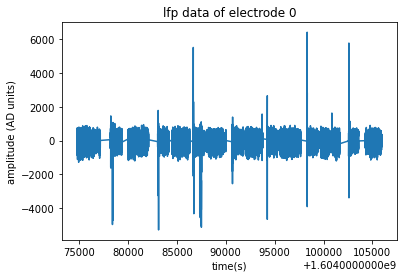

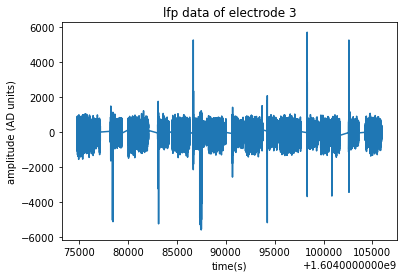

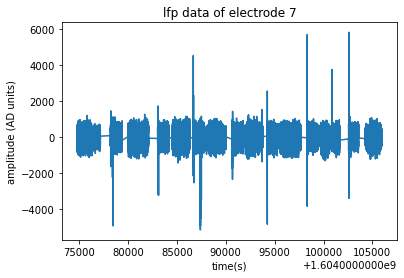

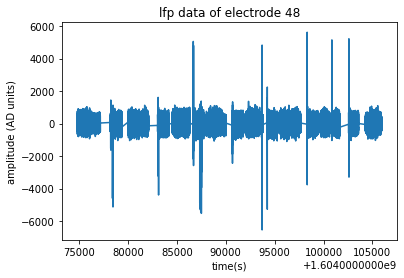

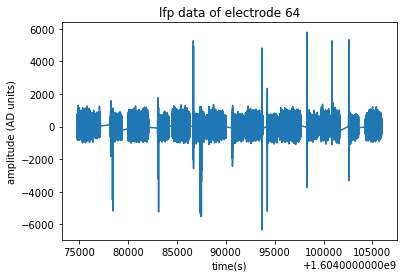

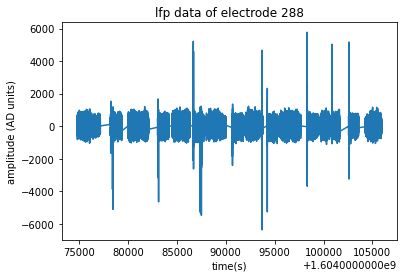

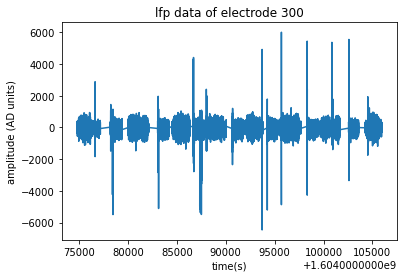

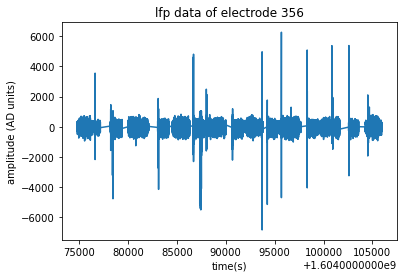

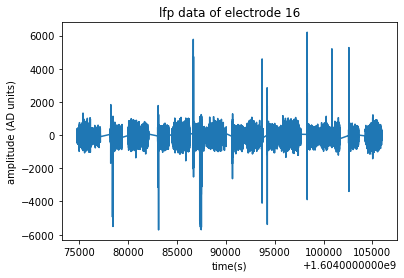

In [37]:
%matplotlib inline
for ix in range(len(lfp_data[0])):
    plt.figure()
    plt.plot(lfp_timestamps,lfp_data[:,ix])
    plt.title(f'lfp data of electrode {electrodes[ix]}') 
    plt.xlabel('time(s)')
    plt.ylabel('amplitude (AD units)')

## plot 1 electrode, interactive

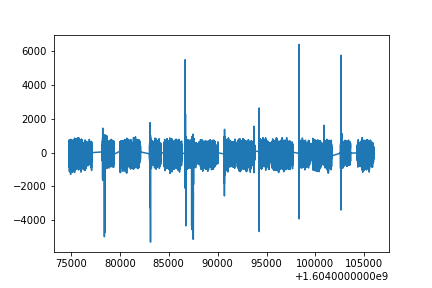

In [38]:
%matplotlib widget 
plt.plot(lfp_timestamps,lfp_data[:,0])

### plot raw data, in this case downsampled to compare to lfp

In [ ]:
# %matplotlib inline
# plt.plot(raw_timestamps[::1000],raw_data[::1000,0])
# plt.title('raw, downsampled data')
# plt.xlabel('time(s)')
# plt.ylabel('amplitude (uV)')

Text(0, 0.5, 'amplitude (uV)')

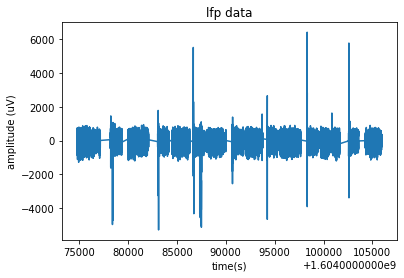

In [39]:
%matplotlib inline
plt.plot(lfp_timestamps,lfp_data[:,0])
plt.title('lfp data')
plt.xlabel('time(s)')
plt.ylabel('amplitude (uV)')

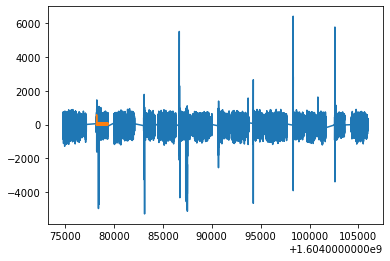

In [144]:
# %matplotlib inline
# plt.plot(lfp_timestamps,lfp_data[:,0])
# plt.plot(position_info.index,position_info.head_speed)

In [352]:
# position_info.iloc[0:50]
# lfp_timestamps

<HDF5 dataset "timestamps": shape (23870420,), type "<f8">

# plot smaller interval, with both raw and lfp data
## set params in next cell, plot in second

In [40]:
plot_times_start = 100 #in seconds
plot_times_end = 101 # in seconds
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate') #original data sampling rate
electrode_num_index= 5

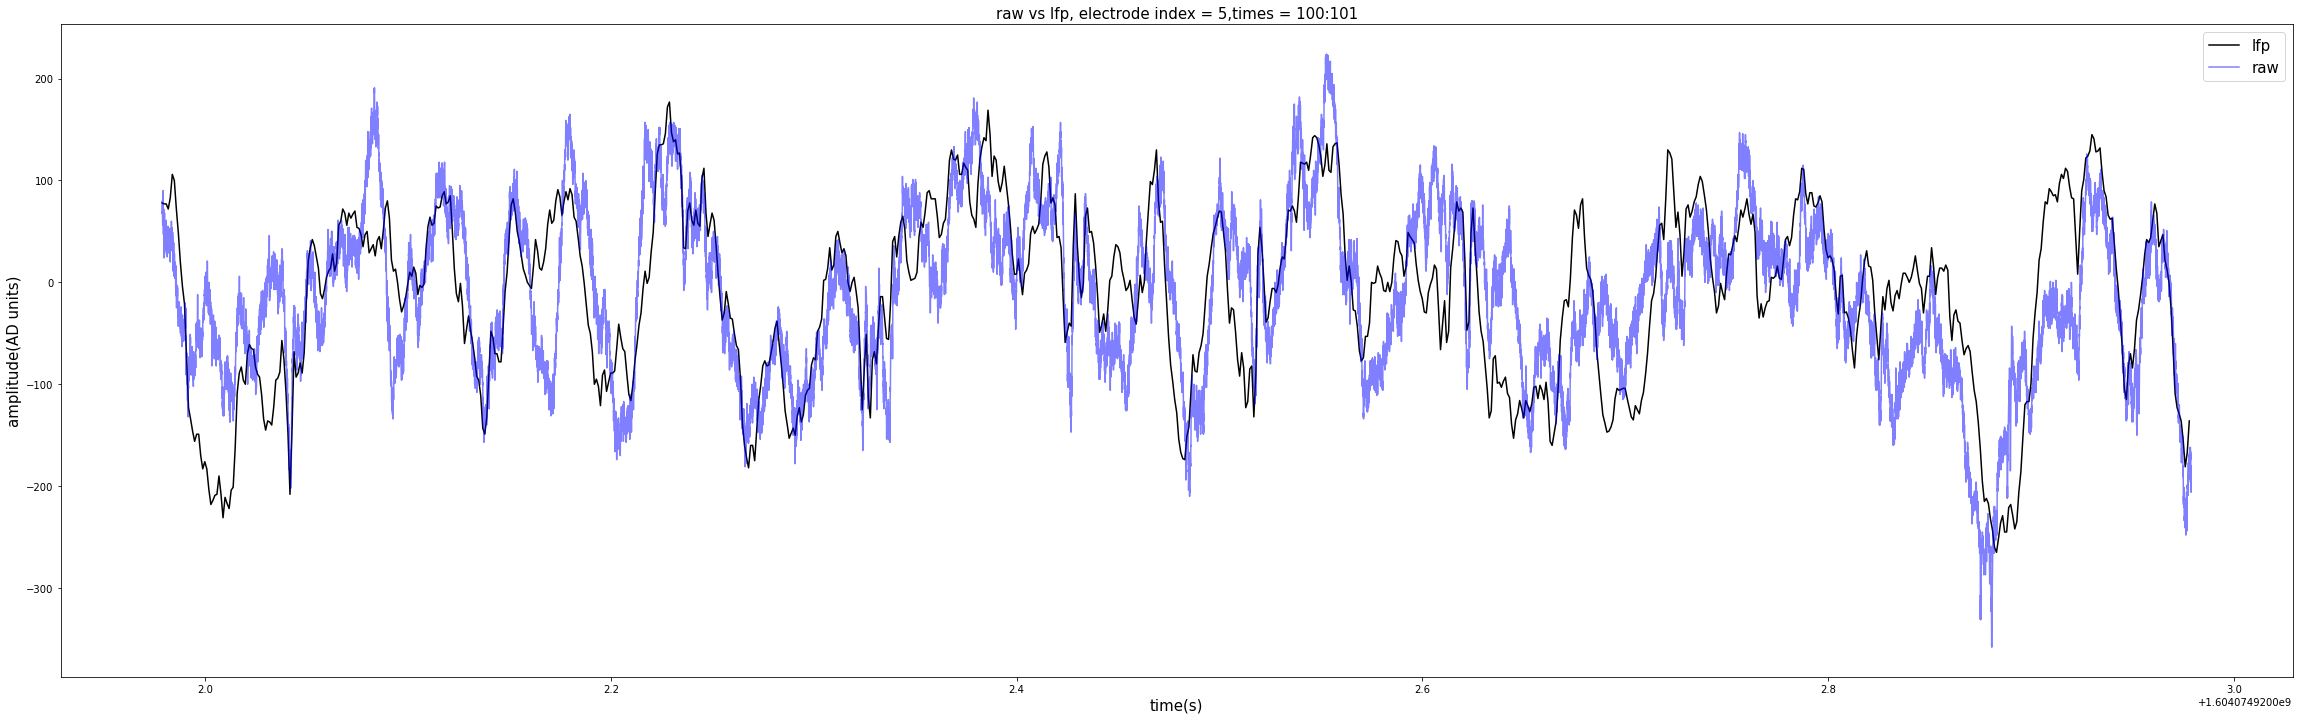

In [41]:
plot_times_lfp = lfp_timestamps[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp]
plot_data_lfp = lfp_data[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp,electrode_num_index]

plot_times_raw = raw_timestamps[plot_times_start*sampling_rate_orig:plot_times_end*sampling_rate_orig]
plot_data_raw=raw_data[plot_times_start*sampling_rate_orig:plot_times_end*sampling_rate_orig,electrode_num_index]

plt.figure(figsize=(40,12))
plt.plot(plot_times_lfp,plot_data_lfp,'k-',label='lfp')
plt.plot(plot_times_raw,plot_data_raw,'b-',label='raw',alpha=.5)
plt.title(f'raw vs lfp, electrode index = {electrode_num_index},times = {plot_times_start}:{plot_times_end}',fontsize=15)
plt.xlabel('time(s)',fontsize=15)
plt.ylabel('amplitude(AD units)',fontsize=15)
plt.legend(fontsize=15)

In [105]:
#this cell will compare the lfp from 2 electrodes, (have to change the last value in plot_data_____ to choose electrodes)
#names are not accruate- no "raw" here 

# plot_times_lfp = lfp_timestamps[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp]
# plot_data_lfp = lfp_data[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp,0]

# plot_times_raw =  lfp_timestamps[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp]
# plot_data_raw=lfp_data[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp,1]

# plt.figure(figsize=(20,12))
# plt.plot(plot_times_lfp,plot_data_lfp,'k-',label='lfp 0')
# plt.plot(plot_times_raw,plot_data_raw,'b-',label='lfp 1',alpha=.5)
# plt.title(f'lfp vs lfp- 2 diff electrodes,times = {plot_times_start}:{plot_times_end}',fontsize=15)
# plt.xlabel('time(s)',fontsize=15)
# plt.ylabel('amplitude(AD units)',fontsize=15)
# plt.legend(fontsize=15)

In [ ]:
# plt.scatter(lfp_eseries.timestamps, lfp_eseries.data[:,0])



In [71]:
# get_electrode_indices(lfp_eseries, electrodes)



[0, 1, 2, 3]

In [ ]:
#starting to get a method to just look at 1 interval. 
# works well for first interval which starts from 0, probably a better way 
#to do this if we want to pursue 

In [42]:
intervals = (IntervalList & {'nwb_file_name': nwb_file_name, 'interval_list_name' : 'raw data valid times'}).fetch1('valid_times')
intervals



array([[1.60407482e+09, 1.60407718e+09],
       [1.60407821e+09, 1.60407941e+09],
       [1.60408002e+09, 1.60408210e+09],
       [1.60408303e+09, 1.60408417e+09],
       [1.60408450e+09, 1.60408632e+09],
       [1.60408665e+09, 1.60408703e+09],
       [1.60408703e+09, 1.60408781e+09],
       [1.60408801e+09, 1.60409005e+09],
       [1.60409063e+09, 1.60409179e+09],
       [1.60409198e+09, 1.60409202e+09],
       [1.60409202e+09, 1.60409381e+09],
       [1.60409420e+09, 1.60409490e+09],
       [1.60409490e+09, 1.60409490e+09],
       [1.60409490e+09, 1.60409501e+09],
       [1.60409501e+09, 1.60409523e+09],
       [1.60409523e+09, 1.60409528e+09],
       [1.60409545e+09, 1.60409768e+09],
       [1.60409828e+09, 1.60409941e+09],
       [1.60409967e+09, 1.60410165e+09],
       [1.60410256e+09, 1.60410304e+09],
       [1.60410304e+09, 1.60410304e+09],
       [1.60410304e+09, 1.60410357e+09],
       [1.60410427e+09, 1.60410460e+09],
       [1.60410460e+09, 1.60410594e+09]])

In [43]:
run1 = (IntervalList & {'nwb_file_name': nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
                                                   

In [44]:
i1_length = intervals[1][1] -  intervals[1][0]
lfp_i1_length = i1_length*1000

In [275]:
# i1s= intervals[0][0]
# i1e = intervals[0][1]

Text(0, 0.5, 'amplitude (uV)')

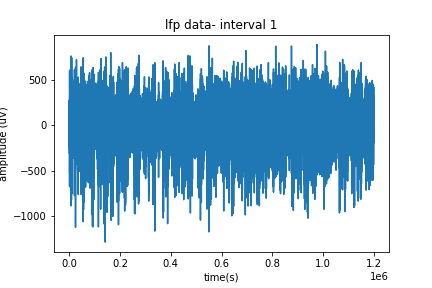

In [45]:
%matplotlib widget
plt.plot(lfp_eseries.data[0:int(lfp_i1_length),0])
plt.title('lfp data- interval 1')
plt.xlabel('time(s)')
plt.ylabel('amplitude (uV)')

In [6]:
# orig_eseries = (Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw']
# orig_elect_indeces = get_electrode_indices(orig_eseries, lfp_band_electrode_ids)

# lfp_eseries = (LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp']
# lfp_elect_indeces = get_electrode_indices(lfp_eseries, lfp_band_electrode_ids)

# lfp_band_eseries = (LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']
# lfp_band_elect_indeces = get_electrode_indices(lfp_band_eseries, lfp_band_electrode_ids)



NameError: name 'lfp_band_electrode_ids' is not defined

In [ ]:
#referencing- at what step, how is it doing it? 
#making plots on smaller by using the timestamps 
#once I find the method, let alison know before i deep dive into it 
#theta! useful to have context

#theta- reference. for theta! not one on wiggly- start with an easy animal (run by alison) 
#an easy way in the end to query the data, find the reference 

#theta- on un referenced data? theta code! (unlike ripples, which we do want referenced and in CA1!
#for the lfp band tables, what are we doing, populate function (make)- understanding the columns 
#after I understand that, good point to talk 

## theta filtering!

In [46]:
lfp_sampling_rate = (LFP() & {'nwb_file_name' : nwb_file_name}).fetch1('lfp_sampling_rate')
lfp_sampling_rate
filter_name = 'Theta 5-11 Hz'
# FirFilter().add_filter(filter_name, lfp_sampling_rate, 'bandpass', [4, 5, 11, 12], 'theta filter for 1 Khz data')

In [47]:
FirFilter()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Delta 0.5-4 Hz,1000,lowpass,0.25,0.5,4.0,5.0,delta filter for 1 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,30000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
Ripple 150-250 Hz,1000,lowpass,140.0,150.0,250.0,260.0,ripple band filter for 1 kHz data,=BLOB=,=BLOB=
Theta 5-11 Hz,1000,lowpass,4.0,5.0,11.0,12.0,theta filter for 1 KHz data,=BLOB=,=BLOB=


In [246]:
#should have a way of getting the tetrode references for channels that are not dead, to add them to LFP table 

Next we add an entry for the LFP Band and the electrodes we want to filter

In [449]:
# assume that we've filtered these electrodes; change this if not
# lfp_band_electrode_ids = [300]
lfp_band_electrode_ids = lfp_electrode_ids_theta

# set the interval list name corresponding to the second epoch (a run session)
interval_list_name = 'raw data valid times'

# set the reference to -1 to indicate no reference for all channels
ref_elect = [-1]

# desired sampling rate
lfp_band_sampling_rate = 1000 #1500? 

In [450]:
lfp_band_electrode_ids

[7, 16, 300]

In [451]:
LFPBandSelection() & {'nwb_file_name':nwb_file_name}

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter


In [452]:
LFPBandSelection().set_lfp_band_electrodes(nwb_file_name, lfp_band_electrode_ids, filter_name, interval_list_name, ref_elect, lfp_band_sampling_rate)

Check to make sure it worked

In [453]:
(LFPBandSelection() & {'nwb_file_name' : nwb_file_name}& {'target_interval_list_name':interval_list_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0


In [390]:
# LFPBandSelection()

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
beans20190718_emonroe_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210109_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210110_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210111_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210112_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210113_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210114_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210115_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210116_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0
CH5_20210117_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1.0


In [454]:
LFPBand & {'nwb_file_name':nwb_file_name}
# (LFPBandSelection() & {'nwb_file_name' : nwb_file_name}).delete()

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file


In [455]:
LFPBand().populate([(LFPBandSelection() & {'nwb_file_name' : nwb_file_name} & {'target_interval_list_name':interval_list_name}).proj()])
LFPBand() & {'nwb_file_name' : nwb_file_name}

Writing new NWB file senor20201030_8AG638FOY0.nwb
Interval stop time 1604105937.9980476 is larger than last timestamp 1604105937.9970477, using last timestamp instead


nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,senor20201030_8AG638FOY0.nwb,raw data valid times lfp band 1000Hz,b9acc68c-5655-4ace-ad84-cec1e812560c


In [456]:
(LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']

filtered data pynwb.ecephys.ElectricalSeries at 0x140359583805152
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (23870418, 3), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (23870418,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [500]:
theta_eseries = (LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']
theta_timestamps = theta_eseries.timestamps
theta_data = theta_eseries.data
theta_eseries

filtered data pynwb.ecephys.ElectricalSeries at 0x140359583805152
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (23870418, 3), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (23870418,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [514]:
(Electrode() & {'nwb_file_name' : nwb_file_name})

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,bad_channel if electrode is 'good' or 'bad' as observed during recording,x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal -- current workaround
senor20201030_.nwb,0,0,tetrode_12.5,0,0,6,0,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,1,tetrode_12.5,0,1,6,1,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,2,tetrode_12.5,0,2,6,2,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,0,3,tetrode_12.5,0,3,6,3,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,4,tetrode_12.5,0,0,6,4,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,5,tetrode_12.5,0,1,6,5,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,6,tetrode_12.5,0,2,6,6,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,1,7,tetrode_12.5,0,3,6,7,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,40,tetrode_12.5,0,0,6,40,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
senor20201030_.nwb,10,41,tetrode_12.5,0,1,6,41,17,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [542]:
electrode_id = 300

theta_data_electrode_order = (LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data'].electrodes[:]

lfp_data_electrode_order = (LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp'].electrodes[:]

raw_data_electrode_order = (Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw'].electrodes[:]


# theta_data_electrode_order[theta_data_electrode_order.id == electrode_id

ValueError: /stelmo/nwb/raw/senor20201030.nwb:/general/extracellular_ephys/0 has not been built

In [554]:
nwb_file_name

'senor20201030_.nwb'

In [ ]:
Elect

In [568]:
(Electrode & {'nwb_file_name' : nwb_file_name}).fetch_nwb()

AttributeError: 'Electrode' object has no attribute 'fetch_nwb'

In [556]:
import pynwb

In [573]:
with pynwb.NWBHDF5IO('/stelmo/nwb/raw/senor20201030.nwb', 'r', load_namespaces=True) as io:
    nwbf = io.read()
    print(nwbf.acquisition['e-series'].electrodes[:])
    # print(nwbf.electrodes.id[:])

       x    y    z  imp location filtering  \
id                                           
0    0.0  0.0  0.0  0.0     None      None   
1    0.0  0.0  0.0  0.0     None      None   
2    0.0  0.0  0.0  0.0     None      None   
3    0.0  0.0  0.0  0.0     None      None   
4    0.0  0.0  0.0  0.0     None      None   
..   ...  ...  ...  ...      ...       ...   
379  0.0  0.0  0.0  0.0     None      None   
380  0.0  0.0  0.0  0.0     None      None   
381  0.0  0.0  0.0  0.0     None      None   
382  0.0  0.0  0.0  0.0     None      None   
383  0.0  0.0  0.0  0.0     None      None   

                                                 group group_name  hwChan  \
id                                                                          
0    0 abc.NwbElectrodeGroup at 0x140355922036096\n...          0      56   
1    0 abc.NwbElectrodeGroup at 0x140355922036096\n...          0      58   
2    0 abc.NwbElectrodeGroup at 0x140355922036096\n...          0      60   
3    0 abc.NwbEl

In [555]:
# (Raw() & {'nwb_file_name' : 'senor20201030.nwb'}).fetch_nwb()[0]['raw'].electrodes

IndexError: list index out of range

In [582]:
raw_data_electrode_order = (Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw'].data[0]


raw_data_electrode_order


array([ 223,  326,  304,  268,  180,  226,  213,  260,  153,  173,  188,
        147,  232,  139,  144,  209,   60,   53,   20,   62,  302,  198,
        173,  297,   33,   47,   56,   14,  120,   82,   18,   79,   69,
         -5,    1,   11,    3,    4,  -22,   96,  106,   72,   28,   26,
        122,  181,  162,   20,   48,    6,  120,    3,  -42,   44,   46,
         34,  173,  340,  230,   96,  153,  109,  208,   82,    1,   14,
        -36,   -1,  268,  200,  182,   40,  -12,  -28,  -17,   61,   12,
         15,    6,  -13,  122,   79,   37,   61,   51,  109,  115,   43,
        120,  253,   74,   40,  -38,  -55,   23,   25,   54,   65,   95,
        134,  165,  266,  366,  455,    6,   20,   26,   48,  542,  511,
        552,  583,  542,  538,  543,  502,  491,  366,  278,  212,  179,
        147,  106,  142,   91,  114,   93,   60,   49,   46,   40,   17,
         28,   17,  -16,  -29,  -48,  -34,  -37,  -26,  -23,  -26,    3,
        -41,  -38,  -31,  -32,  -32,  -30,  -53,  -

In [539]:
t = [theta_data_electrode_order.index==electrode_id][0] 
theta_index = np.where(t)[0][0]

l = [lfp_data_electrode_order.index==electrode_id][0] 
lfp_index = np.where(l)[0][0]

lfp_index 

7

In [476]:
# (LFPBand() & {'nwb_file_name' : nwb_file_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,senor20201030_8AG638FOY0.nwb,raw data valid times lfp band 1000Hz,b9acc68c-5655-4ace-ad84-cec1e812560c


In [458]:
# theta_data

<HDF5 dataset "data": shape (23870418, 3), type "<i2">

In [482]:
# (LFPBandSelection().LFPBandElectrode() & {'nwb_file_name' : nwb_file_name})


nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,1,7,-1
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,33,300,-1
senor20201030_.nwb,Theta 5-11 Hz,1000,raw data valid times,1000,4,16,-1


In [481]:
# (LFPSelection().LFPElectrode() & {'nwb_file_name' : nwb_file_name})

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
senor20201030_.nwb,0,0
senor20201030_.nwb,0,3
senor20201030_.nwb,1,7
senor20201030_.nwb,12,48
senor20201030_.nwb,16,64
senor20201030_.nwb,33,288
senor20201030_.nwb,33,300
senor20201030_.nwb,33,356
senor20201030_.nwb,4,16


In [501]:
plot_times_start = 1000 #in seconds
plot_times_end = 1001 # in seconds
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate') #original data sampling rate
electrode_num_index_raw = 300
electrode_num_index_lfp = 6
electrode_num_index_theta = 1
electrode_id = 300



In [ ]:
#need a way of looking at electrodes, indexing them seperately by raw and theta filtered. 

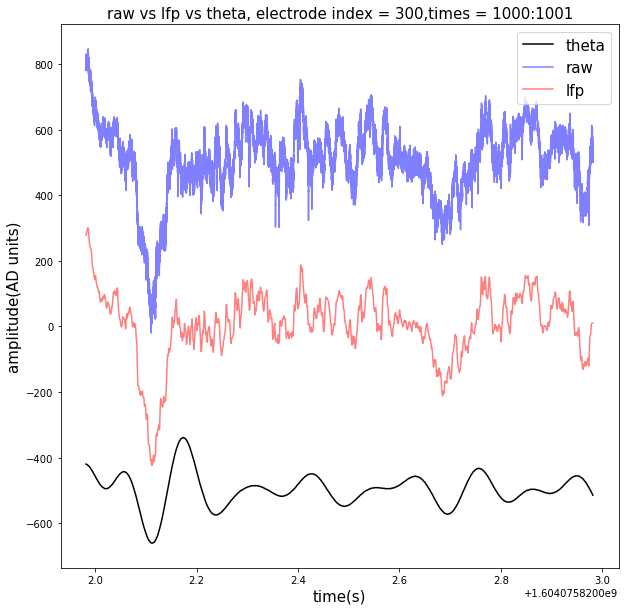

In [578]:
plot_times_lfp = lfp_timestamps[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp]
plot_data_lfp = lfp_data[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp,lfp_index]

plot_times_raw = raw_timestamps[plot_times_start*sampling_rate_orig:plot_times_end*sampling_rate_orig]
plot_data_raw=raw_data[plot_times_start*sampling_rate_orig:plot_times_end*sampling_rate_orig,electrode_id-1]

plot_times_theta = theta_timestamps[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp]
plot_data_theta=theta_data[plot_times_start*sampling_rate_lfp:plot_times_end*sampling_rate_lfp,theta_index]


%matplotlib inline

plt.figure(figsize=(10,10))
plt.plot(plot_times_theta,plot_data_theta-500,'k-',label='theta')
plt.plot(plot_times_raw,plot_data_raw+500,'b-',label='raw',alpha=.5)
plt.plot(plot_times_lfp,plot_data_lfp,'r-',label='lfp',alpha=.5)

# 
plt.title(f'raw vs lfp vs theta, electrode index = {electrode_id},times = {plot_times_start}:{plot_times_end}',fontsize=15)
plt.xlabel('time(s)',fontsize=15)
plt.ylabel('amplitude(AD units)',fontsize=15)
plt.legend(fontsize=15)

# now i specifically want to look only at run 1. 
#using the IntervalList table

In [145]:
# here i want to plot the theta during run 1 
# intervals = (IntervalList & {'nwb_file_name': nwb_file_name, 'interval_list_name' : 'raw data valid times'}).fetch1('valid_times')
# intervals
run1 = (IntervalList & {'nwb_file_name': nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
run1
# run1
# print(lfp_timestamps[0],raw_timestamps[0])
# print(run_1_lfp,run_1_raw)


array([[1.60407821e+09, 1.60407941e+09]])

In [57]:
#find the indices where timestamps are within the run1 times from interval list. could also do by some version of timestamps[timestamps>run1[0][0]]
run_1_lfp = np.argwhere(np.logical_and(lfp_timestamps > run1[0][0], lfp_timestamps< run1[0][1]))
run_1_raw = np.argwhere(np.logical_and(raw_timestamps > run1[0][0], raw_timestamps< run1[0][1]))
run_1_theta = np.argwhere(np.logical_and(theta_timestamps > run1[0][0], theta_timestamps< run1[0][1]))


# now load position/speed info to make sure theta looks good while rat is running

In [ ]:
position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

Text(0, 0.5, 'Amplitude- \ntheta filtered \n AD units')

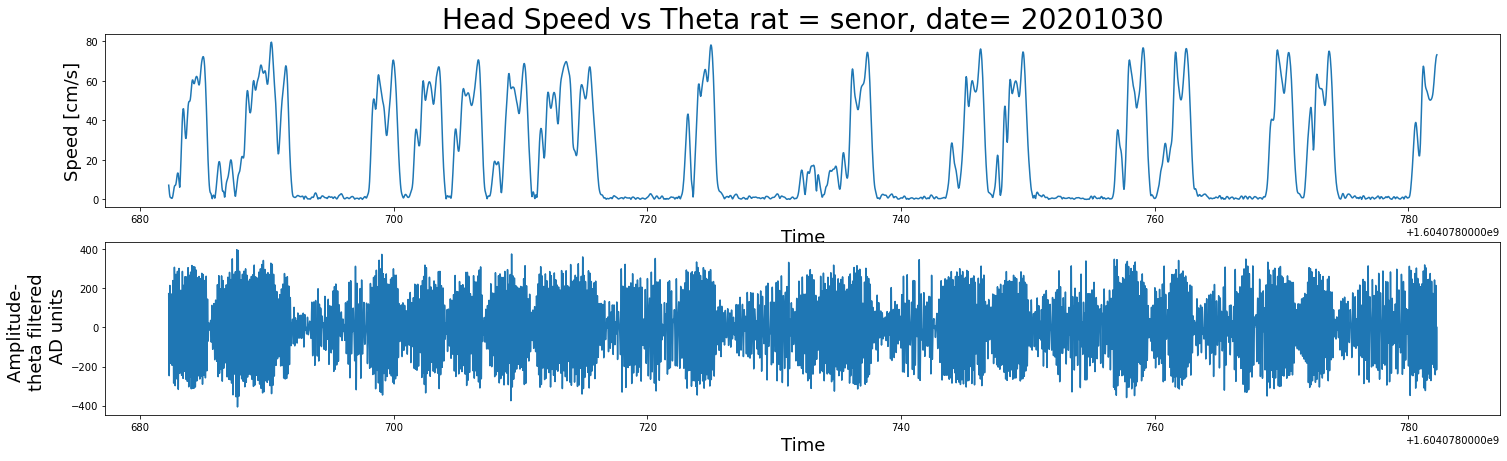

In [424]:
# position_timestamps=position_info.index
# position_data = position_info.head_speed.values
import re
temp = re.findall(r'\d+', nwb_file_name)
day = list(map(int, temp))
rat = 'senor'



time_interval_s = 100
time_from_start = 475


position_start_timestamp = (position_info.index>run1[0][0] +time_from_start)
position_end_timestamps = (position_info.index<run1[0][0]+time_from_start + time_interval_s)
position_x = position_info.index[position_start_timestamp & position_end_timestamps]
position_y = position_info.head_speed[position_start_timestamp & position_end_timestamps]
position_y

lfp_start_timestamp = lfp_timestamps>run1[0][0] +time_from_start
lfp_end_timestamp = (lfp_timestamps<run1[0][0]+time_interval_s+time_from_start)
lfp_x = lfp_timestamps[lfp_start_timestamp & lfp_end_timestamp]
lfp_y = lfp_data[(lfp_start_timestamp & lfp_end_timestamp),0]

theta_start_timestamp = theta_timestamps>run1[0][0] +time_from_start
theta_end_timestamp = (theta_timestamps<run1[0][0]+time_interval_s+time_from_start)
theta_x = theta_timestamps[theta_start_timestamp & theta_end_timestamp]
theta_y = theta_data[(theta_start_timestamp & theta_end_timestamp),0]


# (position_start_timestamp & position_end_timestamps)[1:500]
fig, ax = plt.subplots(2, 1, figsize=(25, 7))
ax[0].plot(position_x, position_y)
ax[0].set_xlabel('Time', fontsize=18)
ax[0].set_ylabel('Speed [cm/s]', fontsize=18)
ax[0].set_title(f'Head Speed vs Theta rat = {rat}, date= {day[0]}', fontsize=28)

ax[1].plot(theta_x, theta_y)
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Amplitude- \ntheta filtered \n AD units', fontsize=18)


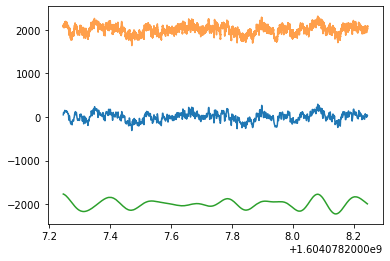

In [429]:

#Working yay, make progress here! 
#write a function for this kind of plot.. heres the start and stop time, go get the things in between!
#plot theta function, from time a to time b. 

# plt.plot(lfp_timestamps[run_1_lfp][0:100],lfp_data[run_1_lfp[0:100],0])

# plt.plot(raw_timestamps[run_1_raw][0:100],raw_data[run_1_raw[0:100],0]+2000,alpha=.5)

# plt.plot(theta_timestamps[run_1_theta][0:100],theta_data[run_1_theta[0:100],0]-2000)




plt.plot(lfp_timestamps[run_1_lfp][0:1*sampling_rate_lfp],lfp_data[run_1_lfp[0:1*sampling_rate_lfp],0])

plt.plot(raw_timestamps[run_1_raw][0:1*sampling_rate_orig],raw_data[run_1_raw[0:1*sampling_rate_orig],0]+2000,alpha=.75)

plt.plot(theta_timestamps[run_1_theta][0:1*sampling_rate_lfp],theta_data[run_1_theta[0:1*sampling_rate_lfp],0]-2000)

# plt.plot(position_info.index[0:100],position_info.head_speed.iloc[0:100])

Text(0, 0.5, 'speed (cm/s)')

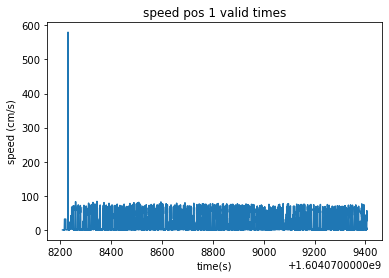

In [15]:
# plt.plot(position_info.head_speed)
# plt.title('speed pos 1 valid times')
# plt.xlabel('time(s)')
# plt.ylabel('speed (cm/s)')

(1604078207.2046502, 1604079406.0654237)

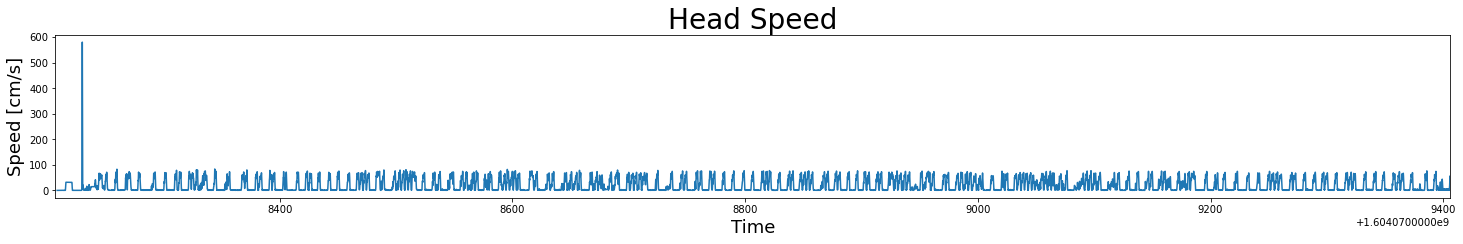

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(25, 3))
# ax.plot(position_info.index, position_info.head_speed)
# ax.set_xlabel('Time', fontsize=18)
# ax.set_ylabel('Speed [cm/s]', fontsize=18)
# ax.set_title('Head Speed', fontsize=28)
# ax.set_xlim((position_info.index.min(), position_info.index.max()))

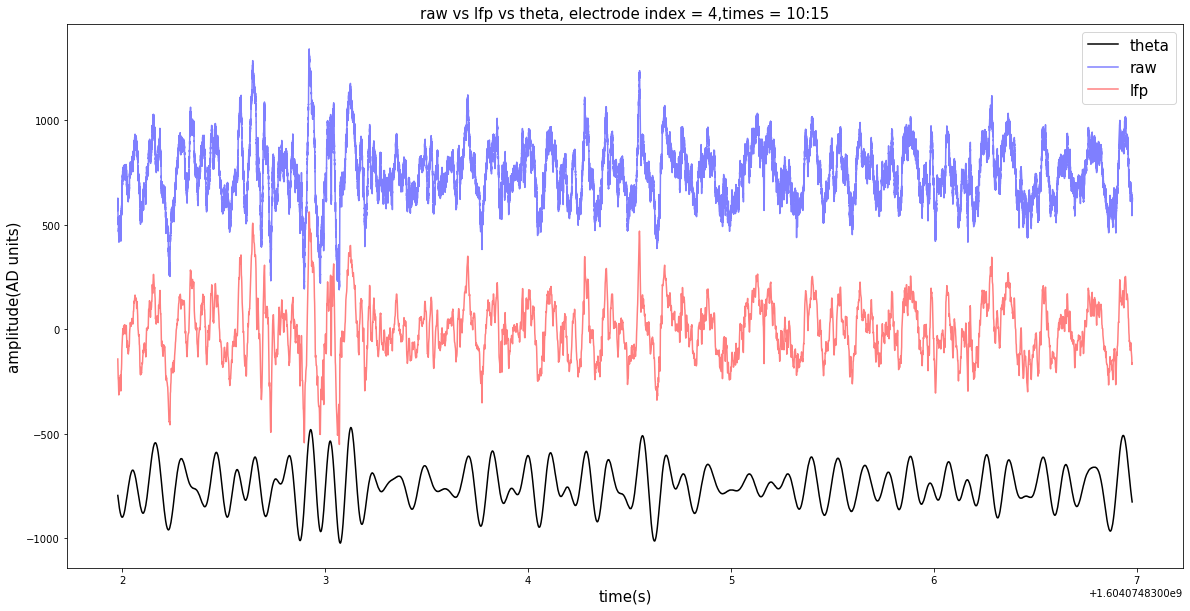

In [136]:
# #user select! Electrodes, times to start and end
# electrode_id = 4
# plot_times_start = 10 #in seconds
# plot_times_end = 15 # in seconds


# #sampling rate, manually defined for now for theta/lfp. will be a problem later if we choose to sample theta at different rate. 
# sampling_rate_lfp = 1000 #lfp sampling rate
# sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
# %matplotlib inline

# #get the index for eseries data corresponding to electrode ID of choice. 
# lfp_index = get_electrode_indices(lfp_eseries,[electrode_id])
# raw_index = get_electrode_indices(orig_eseries,[electrode_id])
# theta_index = get_electrode_indices(theta_eseries,[electrode_id]) 


# #get the sample corresponding to start and end times, though maybe I should change this to be by timestamp. 
# sample_start_lfp = plot_times_start * sampling_rate_lfp
# sample_end_lfp = plot_times_end * sampling_rate_lfp
# plot_times_lfp = lfp_timestamps[sample_start_lfp:sample_end_lfp]
# plot_data_lfp = lfp_data[sample_start_lfp:sample_end_lfp,lfp_index]

# #get samples for start and end time for raw, and then mask the raw data and pull out data for electrode.
# sample_start_raw = plot_times_start*sampling_rate_orig
# sample_end_raw = plot_times_end*sampling_rate_orig
# plot_times_raw = raw_timestamps[sample_start_raw:sample_end_raw]
# plot_data_raw = raw_data[sample_start_raw:sample_end_raw,raw_index]

# plot_times_theta = theta_timestamps[sample_start_lfp:sample_end_lfp]
# plot_data_theta = theta_data[sample_start_lfp:sample_end_lfp,theta_index]

# offset = 750 # 0 or 500 if you want them seperated

# plt.figure(figsize=(20,10))
# plt.plot(plot_times_theta,plot_data_theta-offset,'k-',label='theta')
# plt.plot(plot_times_raw,plot_data_raw+offset,'b-',label='raw',alpha=.5)
# plt.plot(plot_times_lfp,plot_data_lfp,'r-',label='lfp',alpha=.5)
# plt.title(f'raw vs lfp vs theta, electrode index = {electrode_id},times = {plot_times_start}:{plot_times_end}',fontsize=15)
# plt.xlabel('time(s)',fontsize=15)
# plt.ylabel('amplitude(AD units)',fontsize=15)
# plt.legend(fontsize=15)

Text(0, 0.5, 'Amplitude- \ntheta filtered \n AD units')

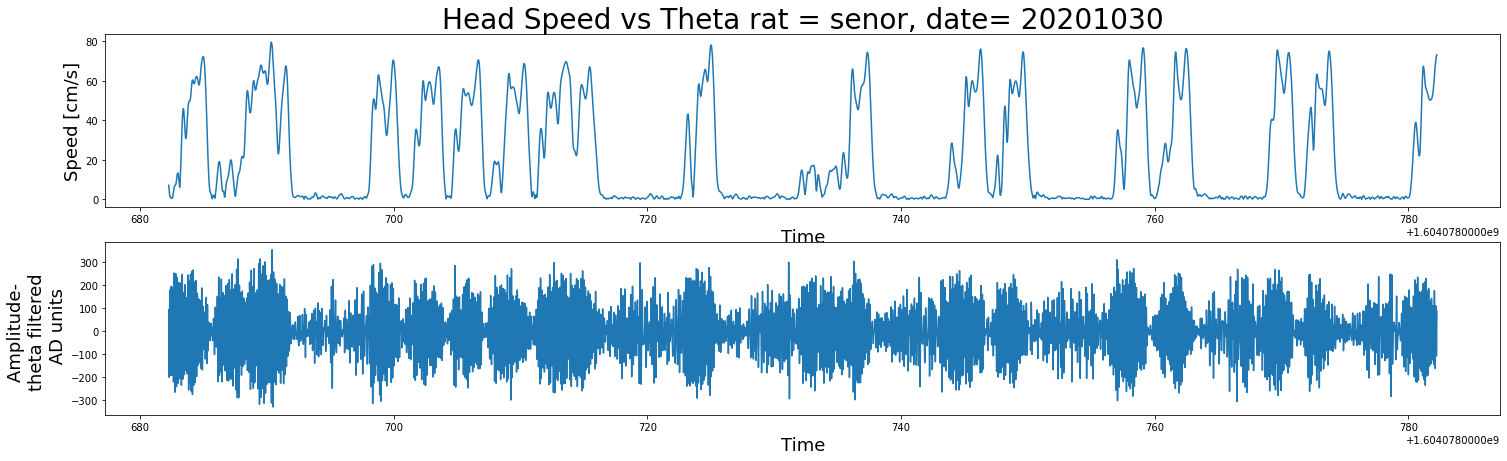

In [77]:
# #get the dat and rat name from nwb file name
# import re
# temp = re.findall(r'\d+', nwb_file_name)
# day = list(map(int, temp))
# rat_name = re.findall('([a-zA-Z ]*)\d*.*', nwb_file_name)[0]

# #user define! How long of a segment, when do oyu wnat it to start? 
# time_interval_s = 100
# time_from_start = 475

# #find the timestamps corresponding to start and end
# #find the position data between those timestamps
# position_start_timestamp = (position_info.index>run1[0][0] +time_from_start)
# position_end_timestamps = (position_info.index<run1[0][0]+time_from_start + time_interval_s)
# position_x = position_info.index[position_start_timestamp & position_end_timestamps]
# position_y = position_info.head_speed[position_start_timestamp & position_end_timestamps]
# position_y

# #find timestamps for lfp data, and find the data between those timestamps
# lfp_start_timestamp = lfp_timestamps>run1[0][0] +time_from_start
# lfp_end_timestamp = (lfp_timestamps<run1[0][0]+time_interval_s+time_from_start)
# lfp_x = lfp_timestamps[lfp_start_timestamp & lfp_end_timestamp]
# lfp_y = lfp_data[(lfp_start_timestamp & lfp_end_timestamp),0]

# #find timestamps for theta data, and find the data between those timestamps
# theta_start_timestamp = theta_timestamps>run1[0][0] +time_from_start
# theta_end_timestamp = (theta_timestamps<run1[0][0]+time_interval_s+time_from_start)
# theta_x = theta_timestamps[theta_start_timestamp & theta_end_timestamp]
# theta_y = theta_data[(theta_start_timestamp & theta_end_timestamp),0]


# make subplot with speed on top and theta on bottom
fig, ax = plt.subplots(2, 1, figsize=(25, 7))
ax[0].plot(position_x, position_y)
ax[0].set_xlabel('Time', fontsize=18)
ax[0].set_ylabel('Speed [cm/s]', fontsize=18)
ax[0].set_title(f'Head Speed vs Theta rat = {rat_name}, date= {day[0]}', fontsize=28)

ax[1].plot(theta_x, theta_y)
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Amplitude- \ntheta filtered \n AD units', fontsize=18)




In [ ]:
import re
temp = re.findall(r'\d+', nwb_file_name)
day = list(map(int, temp))
rat_name = re.findall('([a-zA-Z ]*)\d*.*', nwb_file_name)[0]

#user define! How long of a segment, when do oyu wnat it to start? 
time_interval_s = 15
time_from_start = 475
# electrode_id= 4

position_start_timestamp = (position_info.index>run1[0][0] +time_from_start)
position_end_timestamps = (position_info.index<run1[0][0]+time_from_start + time_interval_s)
position_x = position_info.index[position_start_timestamp & position_end_timestamps]
position_y = position_info.head_speed[position_start_timestamp & position_end_timestamps]
position_y

# for ix in range(len(lfp_electrode_ids)): 
#     electrode_id = lfp_band_electrode_ids[ix]
#     # lfp_index = get_electrode_indices(lfp_eseries,[electrode_id])
#     # raw_index = get_electrode_indices(orig_eseries,[electrode_id])
#     theta_index = get_electrode_indices(theta_eseries,[electrode_id]) 

#     # #find the timestamps corresponding to start and end
#     # #find the position data between those timestamps


#     # #find timestamps for lfp data, and find the data between those timestamps
#     # lfp_start_timestamp = lfp_timestamps>run1[0][0] +time_from_start
#     # lfp_end_timestamp = (lfp_timestamps<run1[0][0]+time_interval_s+time_from_start)
#     # lfp_x = lfp_timestamps[lfp_start_timestamp & lfp_end_timestamp]
#     # lfp_y = lfp_data[(lfp_start_timestamp & lfp_end_timestamp),lfp_index]

#     #find timestamps for theta data, and find the data between those timestamps
#     theta_start_timestamp = theta_timestamps>run1[0][0] +time_from_start
#     theta_end_timestamp = (theta_timestamps<run1[0][0]+time_interval_s+time_from_start)
#     theta_x = theta_timestamps[theta_start_timestamp & theta_end_timestamp]
#     theta_y = theta_data[(theta_start_timestamp & theta_end_timestamp),theta_index[0]]
electrode_ids =lfp_band_electrode_ids
plotting_key['electrode_id'] =electrode_ids
x_elect,y_elect = get_x_y_list(plotting_key)


for ix in range(len(y_elect)):    
    fig, ax = plt.subplots(2, 1, figsize=(25, 7))
    ax[0].plot(position_x, position_y)
    ax[0].set_xlabel('Time', fontsize=18)
    ax[0].set_ylabel('Speed [cm/s]', fontsize=18)
    ax[0].set_title(f'Head Speed vs Theta rat = {rat_name}, date= {day[0]} electrode = {electrode_ids[ix]} \n tetrode {electrode_ids[ix]/4} if over 23, probe', fontsize=28)
    
    theta_x = x_elect[ix]
    theta_y = y_elect[ix]
    ax[1].plot(theta_x, theta_y)
    ax[1].set_xlabel('Time', fontsize=18)
    ax[1].set_ylabel('Amplitude- \ntheta filtered \n AD units', fontsize=18)
 

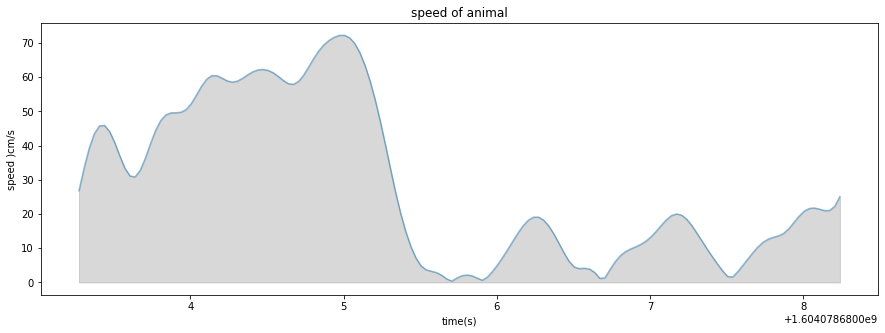

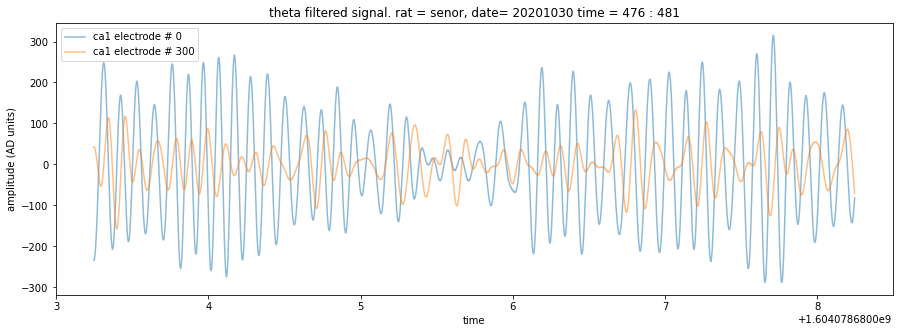

In [196]:
electrodes_to_compare= [0,300]

plotting_key['electrode_id'] =electrodes_to_compare
x_elect,y_elect = get_x_y_list(plotting_key)



plt.figure(figsize=(15,5))
plt.plot(position_x,position_y,alpha=.5) 
plt.fill_between(position_x,position_y,color='grey',alpha=.3)
plt.title('speed of animal')
plt.xlabel('time(s)')
plt.ylabel('speed )cm/s')
plt.figure(figsize=(15,5))


for ix in range(len(y_elect)): 
    theta_x = x_elect[ix]
    theta_y = y_elect[ix]
    plt.plot(theta_x,theta_y,alpha=.5,label=f'ca1 electrode # {electrode_id}')

for ix in range(len(electrodes_to_compare)): 
    electrode_id = electrodes_to_compare[ix]
    # lfp_index = get_electrode_indices(lfp_eseries,[electrode_id])
    # raw_index = get_electrode_indices(orig_eseries,[electrode_id])
    theta_index = get_electrode_indices(theta_eseries,[electrode_id]) 

    #find timestamps for theta data, and find the data between those timestamps
    theta_start_timestamp = theta_timestamps>run1[0][0] +time_from_start
    theta_end_timestamp = (theta_timestamps<run1[0][0]+time_interval_s+time_from_start)
    theta_x = theta_timestamps[theta_start_timestamp & theta_end_timestamp]
    theta_y = theta_data[(theta_start_timestamp & theta_end_timestamp),theta_index[0]]
    
    plt.plot(theta_x,theta_y,alpha=.5,label=f'ca1 electrode # {electrode_id}')

# theta_index = get_electrode_indices(theta_eseries,[reference_1])
# theta_x = theta_timestamps[theta_start_timestamp & theta_end_timestamp]
# theta_y = theta_data[(theta_start_timestamp & theta_end_timestamp),theta_index[0]]
# plt.plot(theta_x,theta_y,color='black', label='reference')
plt.ylabel('amplitude (AD units)')
plt.xlabel('time')
plt.title(f'theta filtered signal. rat = {rat_name}, date= {day[0]} time = {time_from_start} : {time_from_start+time_interval_s}')
plt.legend()
#should make the references a different color, or have some way of checking that the references theta looks different than the rest     
    
    # plt.figure(figsize=(15,5))
    # plt.plot(theta_x,theta_y)
    # plt.title(f'Theta across electrodes rat = {rat_name}, date= {day[0]} electrode {electrode_id} \n tetrode {electrode_id/4}', fontsize=15)
    
    # make subplot with speed on top and theta on bottom
    # fig, ax = plt.subplots((len(lfp_band_electrode_ids)), 1, figsize=(25, 7))
    # ax[ix].plot(theta_x, theta_y)
    # ax[ix].set_xlabel('time', fontsize=18)
    # ax[ix].set_ylabel('theta amplitude', fontsize=18)
    # ax[ix].set_title(f'Theta cross electrodes rat = {rat_name}, date= {day[0]}', fontsize=28)
    

In [ ]:
#this was testing functions, basically trash now but useful to see how those functions were implemented at first. 

# plot_theta(nwb_file_name, 1 ,1, 0, theta_timestamps, theta_data, theta_eseries, run1, sampling_rate_lfp)
# plt.figure()
# plot_lfp(nwb_file_name, 1 ,1, 0, lfp_timestamps, lfp_data, lfp_eseries, run1, sampling_rate_lfp)
# plt.figure()
# plot_raw (nwb_file_name, 1 ,1, 0, raw_timestamps, raw_data, orig_eseries, run1, sampling_rate_orig)


In [ ]:
#user select! Electrodes, times to start and end
electrode_id = 4
plot_times_start = 10 #in seconds
plot_times_end = 15 # in seconds


#sampling rate, manually defined for now for theta/lfp. will be a problem later if we choose to sample theta at different rate. 
sampling_rate_lfp = 1000 #lfp sampling rate
sampling_rate_orig = (LFP() & {'nwb_file_name': nwb_file_name}).fetch1('filter_sampling_rate')
%matplotlib inline

#get the index for eseries data corresponding to electrode ID of choice. 
lfp_index = get_electrode_indices(lfp_eseries,[electrode_id])
raw_index = get_electrode_indices(orig_eseries,[electrode_id])
theta_index = get_electrode_indices(theta_eseries,[electrode_id]) 


#get the sample corresponding to start and end times, though maybe I should change this to be by timestamp. 
sample_start_lfp = plot_times_start * sampling_rate_lfp
sample_end_lfp = plot_times_end * sampling_rate_lfp
plot_times_lfp = lfp_timestamps[sample_start_lfp:sample_end_lfp]
plot_data_lfp = lfp_data[sample_start_lfp:sample_end_lfp,lfp_index]

#get samples for start and end time for raw, and then mask the raw data and pull out data for electrode.
sample_start_raw = plot_times_start*sampling_rate_orig
sample_end_raw = plot_times_end*sampling_rate_orig
plot_times_raw = raw_timestamps[sample_start_raw:sample_end_raw]
plot_data_raw = raw_data[sample_start_raw:sample_end_raw,raw_index]

plot_times_theta = theta_timestamps[sample_start_lfp:sample_end_lfp]
plot_data_theta = theta_data[sample_start_lfp:sample_end_lfp,theta_index]

offset = 750 # 0 or 500 if you want them seperated

plt.figure(figsize=(20,10))
plt.plot(plot_times_theta,plot_data_theta-offset,'k-',label='theta')
plt.plot(plot_times_raw,plot_data_raw+offset,'b-',label='raw',alpha=.5)
plt.plot(plot_times_lfp,plot_data_lfp,'r-',label='lfp',alpha=.5)
plt.title(f'raw vs lfp vs theta, electrode index = {electrode_id},times = {plot_times_start}:{plot_times_end}',fontsize=15)
plt.xlabel('time(s)',fontsize=15)
plt.ylabel('amplitude(AD units)',fontsize=15)
plt.legend(fontsize=15)